In [82]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from dataset_utilits import load_imagesPath_ages_sex
from sklearn.model_selection import train_test_split
import random
import cv2
from sklearn.decomposition import PCA
from operator import itemgetter
from inception_utilits import conv2d_bn, stem_block, inception_a_block, inception_b_block, inception_c_block, reduction_a_block, reduction_b_block
from shapely.geometry import Polygon


In [2]:
train_truth = pd.read_csv('./data.nosync/train/train.csv')
validation_truth = pd.read_csv('./data.nosync/validation/Validation Dataset.csv')
test_truth = pd.read_excel('./data.nosync/test/Bone age ground truth.xlsx')

In [4]:
path_data_dir = 'data.nosync'
full_path = os.path.join(os.getcwd(), path_data_dir)
X_train, age_train, sex_train, X_validation, age_validation, sex_validation, X_test, age_test, sex_test = load_imagesPath_ages_sex(full_path, train_truth, validation_truth, test_truth, None)

prendo le image_names da  /Users/pietroferrazzi/Desktop/uni/human_data/project/HDA-bone-age-prediction/data.nosync/train/images
prendo le image_names da  /Users/pietroferrazzi/Desktop/uni/human_data/project/HDA-bone-age-prediction/data.nosync/validation/images
prendo le image_names da  /Users/pietroferrazzi/Desktop/uni/human_data/project/HDA-bone-age-prediction/data.nosync/test/images


In [129]:
print("X shape:", len(X_test))
print("X train shape:", len(X_train))
print("X test shape:", len(X_validation))

X shape: 200
X train shape: 12611
X test shape: 1425


NameError: name 'age_train' is not defined

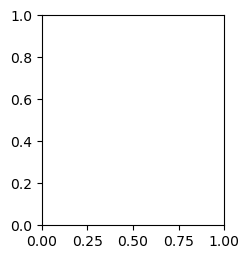

In [3]:
IMG_SHAPE = (100, 100, 3)


def show_image(x):
    plt.imshow(x)

def load_image(img_path, IMG_SHAPE):
    num_row = IMG_SHAPE[1]
    num_col = IMG_SHAPE[0]

    if isinstance(img_path, bytes):
        img_path = img_path.decode()

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = np.array(cv2.resize(img, (num_row, num_col)), dtype='float32')

    return img

def normalize_img(image):
    return tf.cast(image, tf.float32) / 255.

plt.figure(figsize=(8, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    idx = random.randint(0, len(age_train))
    show_image(normalize_img(load_image(X_train[idx], IMG_SHAPE)))
    #plt.title(labels[Y_train[idx]])

Try pca to see if it possible to understand if the images are rotated. Use 2 components, I expect them to be x1(diretricce polso-punta indice) and x2 (orizzontale). Se così fosse, usando immagini dritte, quando ne vedo una che non so se sia dritta o meno potrei verificarlo e ruotarla in caso. Uso un dataset selezionato con immagini dritte. 

(500, 500, 3)
Blue Channel : 0.7341887950897217
Green Channel: 0.7341887950897217
Red Channel  : 0.7341887950897217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


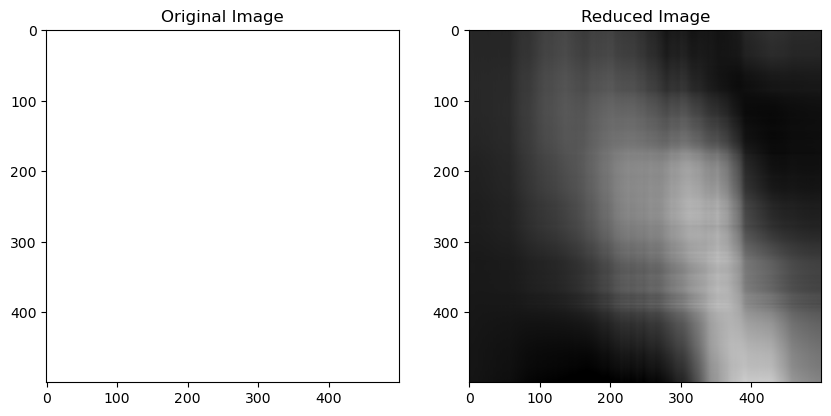

In [120]:

# idx = random.sample(range(0, len(age_train)), n_samples) 
# random_sample = list(itemgetter(*idx)(X_train))

rotated_img = '/Users/pietroferrazzi/Desktop/uni/human_data/project/HDA-bone-age-prediction/data.nosync/train/images/1489.png'
img =  load_image(rotated_img, IMG_SHAPE)
print(img.shape)
blue,green,red = (cv2.split(img))
df_blue = blue/255
df_green = green/255
df_red = red/255

pca_b = PCA(n_components=2)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
pca_g = PCA(n_components=2)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
pca_r = PCA(n_components=2)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)

img_reduced = (cv2.merge((b_arr, g_arr, r_arr)))

fig = plt.figure(figsize = (10, 7.2)) 
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(img)
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced)
plt.show()

# selected_subset = X_train[0:20] # to be defined
# data = []
# for img_path in X_train:
#     img = load_image(img_path, IMG_SHAPE)
#     blue,green,red = cv2.split(img)
#     df_blue = blue/255
#     df_green = green/255
#     df_red = red/255
# df_blue.shape
# pca = PCA(2) # we need 2 principal components.
# converted_data = pca.fit_transform(data)
 
# converted_data.shape

### 2 ways: use the create_dataset function (from_tensor_to_slices) oppure ImageDataGenerator. For the latter, need to open all the data and put them somewhere. For the former, see dataset_implementation

### use ImageDataGenerator

In [5]:
def resize_and_normalize_image(img):
    img = np.array(cv2.resize(img, (IMG_SHAPE[1], IMG_SHAPE[0])), dtype='float32')
    img = img/ 255.
    return img

In [7]:
datagen_train = ImageDataGenerator(preprocessing_function = lambda x: x/255.,
                             width_shift_range=4,  # randomly shift images horizontally
                             height_shift_range=4,  # randomly shift images vertically 
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True)  # randomly flip images
datagen_validation = ImageDataGenerator(preprocessing_function=lambda x: x/255.)
datagen_test = ImageDataGenerator(preprocessing_function = lambda x: x/255.)

In [27]:
batch_size = 32
train_truth = pd.read_csv('./data.nosync/train/train.csv')
validation_truth = pd.read_csv('./data.nosync/validation/Validation Dataset.csv')
train_truth['id'] = train_truth['id'].astype(str) + '.png'
train_generator = datagen_train.flow_from_dataframe(dataframe=train_truth, directory='./data.nosync/train/subset_images', 
                                                    x_col="id",
                                                    y_col="boneage",  
                                                    class_mode="other", target_size=(IMG_SHAPE[0], IMG_SHAPE[1]), 
                                                    batch_size=batch_size)
validation_truth['Image ID'] = validation_truth['Image ID'].astype(str) + '.png'
validation_generator = datagen_validation.flow_from_dataframe(dataframe=validation_truth, directory='./data.nosync/validation/subset_images', 
                                                              x_col="Image ID", 
                                                              y_col="Bone Age (months)", 
                                                              class_mode="other", target_size=(IMG_SHAPE[0], IMG_SHAPE[1]), 
                                                              batch_size=batch_size)

Found 537 validated image filenames.
Found 65 validated image filenames.


/opt/homebrew/anaconda3/envs/hda/lib/python3.10/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 12074 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '
/opt/homebrew/anaconda3/envs/hda/lib/python3.10/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 1360 invalid image filename(s) in x_col="Image ID". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [28]:
batch_size = 32
train_steps = int(np.ceil( train_generator.n / batch_size))
validation_steps = int(np.ceil(validation_generator.n / batch_size))

## MODEL

In [15]:
def Inceptionv4(X_input): #  (input_shape):
    """
    Implementation of the Inception-v4 architecture

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # # Define the input as a tensor with shape input_shape (1 line)
    # X_input = Input(input_shape)

    # Call the above functions for the stem, inception-a, reduction-a, inception-b, reduction-b and inception-c blocks
    X = stem_block(X_input)

    # Four Inception A blocks
    X = inception_a_block(X, 'a1')
    X = inception_a_block(X, 'a2')
    X = inception_a_block(X, 'a3')
    X = inception_a_block(X, 'a4')

    # Reduction A block
    X = reduction_a_block(X)

    # Seven Inception B blocks
    X = inception_b_block(X, 'b1')
    X = inception_b_block(X, 'b2')
    X = inception_b_block(X, 'b3')
    X = inception_b_block(X, 'b4')
    X = inception_b_block(X, 'b5')
    X = inception_b_block(X, 'b6')
    X = inception_b_block(X, 'b7')

    # Reduction B block
    X = reduction_b_block(X)

    # Three Inception C blocks
    X = inception_c_block(X, 'c1')
    X = inception_c_block(X, 'c2')
    X = inception_c_block(X, 'c3')

    # AVGPOOL (1 line). Use "X = AveragePooling2D(...)(X)"
    kernel_pooling = X.get_shape()[1:3]
    X = AveragePooling2D(kernel_pooling, name='avg_pool')(X)
    X = Flatten()(X)

    # Dropout
    X = Dropout(rate = 0.2)(X)

    # Output layer
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    
    # # Create model
    # model = Model(inputs = X_input, outputs = X, name='Inceptionv4')

    # return model
    return X

In [16]:
def DenseLayers(X_input):
    X = Dense(1000, activation='relu', name='first_dense')(X_input)
    X = Dense(1000, activation='sigmoid', name='second_dense')(X)
    return(X)

In [34]:
def model_assembly(input_shape):
    X_input = Input(input_shape)
    X = Inceptionv4(X_input)
    X_out = DenseLayers(X)
    # Create model
    model = Model(inputs = X_input, outputs = X_out, name='Inceptionv4_2Dense')
    return model

In [35]:
model = model_assembly(input_shape = IMG_SHAPE)

model.compile(optimizer="adam", loss="mean_squared_error", metrics=tf.keras.metrics.mean_squared_error)

# Create a callback for early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [36]:
# Fit the model on batches with real-time data augmentation:
history = model.fit(train_generator, 
                    validation_data = validation_generator, 
                    epochs=5, 
                    steps_per_epoch=train_steps,
                    validation_steps=validation_steps,
                    callbacks=[callback])

Epoch 1/5
17/17 [==============================] - 26s 1s/step - loss: 15033.1543 - mean_squared_error: 15033.1543 - val_loss: 14515.5479 - val_mean_squared_error: 14515.5479
Epoch 2/5
17/17 [==============================] - 17s 958ms/step - loss: 14990.0479 - mean_squared_error: 14990.0479 - val_loss: 14464.5820 - val_mean_squared_error: 14464.5820
Epoch 3/5
17/17 [==============================] - 18s 1s/step - loss: 14949.2422 - mean_squared_error: 14949.2422 - val_loss: 14436.4746 - val_mean_squared_error: 14436.4746
Epoch 4/5
17/17 [==============================] - 17s 963ms/step - loss: 14936.8701 - mean_squared_error: 14936.8701 - val_loss: 14431.1113 - val_mean_squared_error: 14431.1113
Epoch 5/5
17/17 [==============================] - 17s 953ms/step - loss: 14934.4336 - mean_squared_error: 14934.4336 - val_loss: 14429.8809 - val_mean_squared_error: 14429.8809


In [37]:
tf.keras.utils.plot_model(model)

In [83]:
def get_cont_max_area(contours):
    pgons = []
    i = 0
    max_idx = -1
    max = 0
    for cont in contours:
        pgons.append( Polygon(zip(list(cont[:,0][:,0]), list(cont[:,0][:,1])) ) )
        if pgons[i].area > max:
            max_idx = i
            max = pgons[i].area
        i = i+1
    return(contours[max_idx])

def extract_hand_mask(img_path, visualize = False):
    img = cv2.imread(img_path)

    # Extract one color channel
    gray = img[:, :, 2]
    ret, thresh_gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
    # Use "opening" morphological operation for clearing some small dots (noise)
    thresh_gray = cv2.morphologyEx(thresh_gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))

    # Use "closing" morphological operation for closing small gaps
    thresh_gray = cv2.morphologyEx(thresh_gray, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9)))

    # find the polygon that contains the hand
    contours,hierarchy = cv2.findContours(thresh_gray, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    cont = get_cont_max_area(contours)
    approx = cv2.approxPolyDP(cont, 0.0015*cv2.arcLength(cont, True), True)
    
    if(visualize):

        (x,y)=cont[0,0]
        img = cv2.drawContours(img, [approx], -1, (0,255,255), 2)
        cv2.putText(img, 'Polygon', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        fig = plt.figure(figsize = (10, 7.2)) 
        fig.add_subplot(121)
        plt.imshow(thresh_gray)
        fig.add_subplot(122)
        plt.imshow(img)
    return thresh_gray, cont


mask = extract_hand_mask('/Users/pietroferrazzi/Desktop/uni/human_data/project/HDA-bone-age-prediction/data.nosync/test/subset_images/4485.png', True)
plt.imshow()